In [95]:
import pandas as pd
import numpy as np

from mplsoccer import Pitch, Sbopen
from mplsoccer import VerticalPitch,Pitch
from mplsoccer import Pitch

In [96]:
data = pd.read_csv(f"./results/wyscout/5414302_df_events.csv")

data = data[['location.x', 'location.y', 'pass.endLocation.x', 'pass.endLocation.y', "player.name", "pass.recipient.name","team.name","minute",'player.id']]

df_merged = data.rename(columns={
'location.x':'x',
'location.y':'y',
'pass.endLocation.x':'end_x',
'pass.endLocation.y':'end_y',
"player.name":"player_name",
"pass.recipient.name":"pass_recipient_name",
"team.name":"team_name",
"minute":"minute",
"player.id":'player_id'
})


In [97]:
df_home_pass = df_merged[df_merged.team_name != 'Denmark']

# Check player play time
home_player_df = df_merged[df_merged.team_name != 'Denmark'].groupby('player_name').agg({'minute': [min, max]}).reset_index()
home_player_df = pd.concat([home_player_df['player_name'], home_player_df['minute']], axis=1)
home_player_df['minutes_played'] = home_player_df['max'] - home_player_df['min']
home_player_df = home_player_df.sort_values('minutes_played', ascending=False)

/tmp/ipykernel_5196/2084634094.py:4: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df_merged[df_merged.team_name != 'Denmark'].groupby('player_name').agg({'minute': [min, max]}).reset_index()
/tmp/ipykernel_5196/2084634094.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df_merged[df_merged.team_name != 'Denmark'].groupby('player_name').agg({'minute': [min, max]}).reset_index()


In [98]:
home_player_name = home_player_df.player_name[:11].tolist()
df_home_pass = df_home_pass[df_home_pass.player_name.isin(home_player_name)]
df_home_pass = df_home_pass[df_home_pass.pass_recipient_name.isin(home_player_name)]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_home_pass["player_name"].unique()):
    passx = df_home_pass.loc[df_home_pass["player_name"] == name]["x"].to_numpy()
    recx = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_home_pass.loc[df_home_pass["player_name"] == name]["y"].to_numpy()
    recy = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #calculate number of passes
    scatter_df.at[i, "no"] = df_home_pass.loc[df_home_pass["player_name"] == name].count().iloc[0]
    
#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 900)

In [ ]:
#Calculate edge width
df_home_pass["pair_key"] = df_home_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_home_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold
lines_df = lines_df[lines_df['pass_count']> 0]

## Passing network

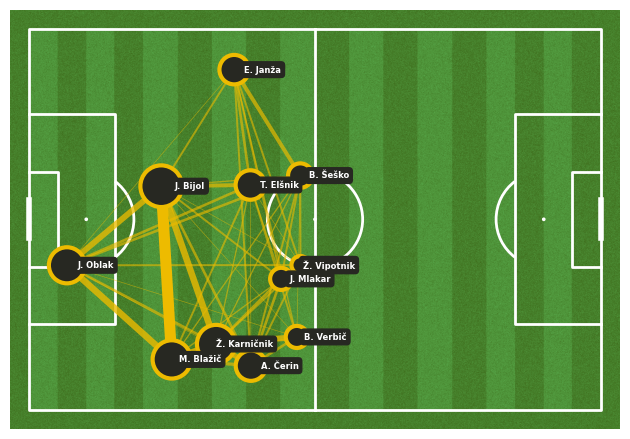

In [ ]:

import matplotlib.pyplot as plt
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)

fig, ax = pitch.draw()

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax, zorder = 3)

for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax, zorder = 4, 
                   bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))
    

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x']
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y']
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x']
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y']
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # adjust the alpha of the lines based on number of passes and set minimum alpha for a fewer pass
        alpha = 0.5 * num_passes / lines_df['pass_count'].max() + 0.5
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax)

plt.savefig('passing_network.png', dpi=400)
plt.show()